In [1]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Input,
    Lambda,
    MaxPool2D,
    Reshape,
    Flatten,
    Dense
)

from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# tsne
from sklearn.manifold import TSNE
import pandas as pd

# load data

In [2]:
(X, y), (X_test, y_test) = mnist.load_data()
X = X[:, :, :, np.newaxis].astype('float32') / 255
X_test = X_test[:, :, :, np.newaxis].astype('float32') / 255

y_categorical = to_categorical(y, 10)
y_test_categorical = to_categorical(y_test, 10)

# model

In [3]:
#arcface
class ArcFace(tf.keras.layers.Layer):
    def __init__(self, n_classes=10, s=1.0, m=0.01, regularizer=None, **kwargs):
        super(ArcFace, self).__init__(**kwargs)
        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.regularizer = regularizers.get(regularizer)

    def build(self, input_shape):
        super(ArcFace, self).build(input_shape[0])
        self.W = self.add_weight(name='W',
                                shape=(input_shape[0][-1], self.n_classes),
                                initializer='glorot_uniform',
                                trainable=True,
                                regularizer=self.regularizer)

    def call(self, inputs):
        x, y = inputs
        c = K.shape(x)[-1]
        # normalize feature
        x = tf.nn.l2_normalize(x, axis=1)
        # normalize weights
        W = tf.nn.l2_normalize(self.W, axis=0)
        # dot product
        logits = x @ W
        # add margin
        # clip logits to prevent zero division when backward
        theta = tf.acos(K.clip(logits, -1.0 + K.epsilon(), 1.0 - K.epsilon()))
        target_logits = tf.cos(theta + self.m)

        logits = logits * (1 - y) + target_logits * y
        # feature re-scale
        logits *= self.s
        out = tf.nn.softmax(logits)

        return out

    def compute_output_shape(self, input_shape):
        return (None, self.n_classes)
    
    def get_config(self):
        config = super(ArcFace, self).get_config()
        config.update({"n_classes": self.n_classes})
        return config

In [4]:
n_categories = 10
weight_decay = 1e-4
inputs = Input(shape=(28,28,1))
yinput = Input(shape=(n_categories,))
x = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
x = Conv2D(32, (3, 3), padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2), data_format="channels_last")(x)
x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2), data_format="channels_last")(x)
x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2), data_format="channels_last")(x)
x = Flatten()(x)
x = Dense(64)(x)
output = ArcFace(n_categories, regularizer=regularizers.l2(weight_decay))([x, yinput])
model = Model(inputs=[inputs, yinput], outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 32)   128         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [10]:
learning_rate=0.01
model.compile(optimizer= Adam(lr=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit([X,y_categorical], y_categorical, batch_size=16, epochs=3, validation_data=([X_test,y_test_categorical], y_test_categorical))

/home/sato/.pyenv/versions/3.7.9/envs/rdd-segmentation/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/3
3750/3750 [==============================] - 51s 13ms/step - loss: 0.2238 - accuracy: 0.9616 - val_loss: 0.2197 - val_accuracy: 0.9869
Epoch 2/3
3750/3750 [==============================] - 50s 13ms/step - loss: 0.2197 - accuracy: 0.9823 - val_loss: 0.2191 - val_accuracy: 0.9870
Epoch 3/3
3750/3750 [==============================] - 50s 13ms/step - loss: 0.2191 - accuracy: 0.9857 - val_loss: 0.2188 - val_accuracy: 0.9904


r 0 980
g 1 1135
b 2 1032
c 3 1010
m 4 982
y 5 892
k 6 958
orange 7 1028
pink 8 974
gray 9 1009


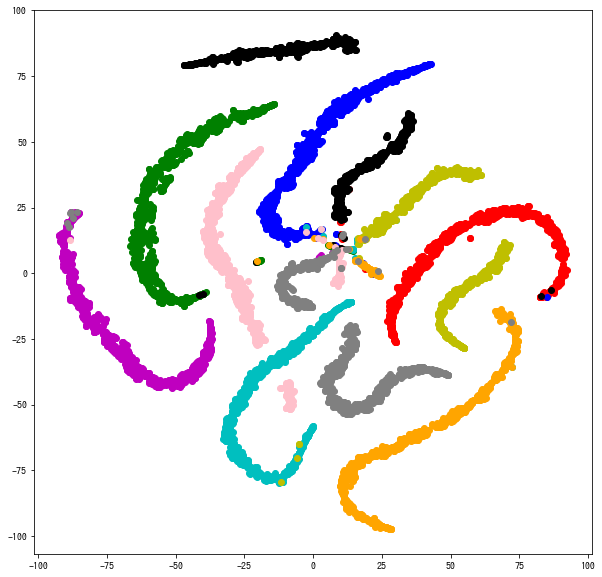

In [11]:
extractor = Model(inputs=model.input[0], outputs=model.layers[-3].output)

feature_list = extractor.predict(X_test)

tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
X_embedded = tsne.fit_transform(feature_list)

# %%
df_defect = pd.concat(
    [
        pd.DataFrame(y_test, columns=["label"]),
        pd.DataFrame(X_embedded, columns=["col1", "col2"]),
    ],
    axis=1,)

categories = [0,1,2,3,4,5,6,7,8,9]
colors = ["r", "g", "b", "c", "m", "y", "k", "orange", "pink", "gray"]
plt.figure(figsize=(10, 10))
for i, v in enumerate(categories):
    tmp_df = df_defect[df_defect["label"] == i]
    print(colors[i], v, len(tmp_df))
    plt.scatter(tmp_df["col1"], tmp_df["col2"], label=v, color=colors[i])

In [51]:
model.predict([X_test[0:3], np.zeros((3,10))])

array([[0.08436599, 0.0813511 , 0.08273904, 0.08290315, 0.08351602,
        0.0821466 , 0.08317196, 0.25601873, 0.08167341, 0.08211391],
       [0.0857701 , 0.08590756, 0.25113225, 0.09178449, 0.0792155 ,
        0.07931087, 0.08172585, 0.08198734, 0.08301166, 0.08015434],
       [0.08133496, 0.25821778, 0.08230421, 0.08251401, 0.08251902,
        0.08315001, 0.08162133, 0.0819144 , 0.08470069, 0.08172357]],
      dtype=float32)

# save model

In [16]:
import tempfile
import os
MODEL_DIR = './models/'
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

export_path = ./models/1

INFO:tensorflow:Assets written to: ./models/1/assets


In [4]:
loaded = tf.saved_model.load('./models/1/')
print(list(loaded.signatures.keys()))

['serving_default']


In [75]:
loaded.signatures["serving_default"].structured_outputs

{'arc_face_1': TensorSpec(shape=(None, 10), dtype=tf.float32, name='arc_face_1')}

In [84]:
loaded.signatures["serving_default"].inputs

[<tf.Tensor 'input_3:0' shape=(None, 28, 28, 1) dtype=float32>,
 <tf.Tensor 'input_4:0' shape=(None, 10) dtype=float32>,
 <tf.Tensor 'unknown:0' shape=() dtype=resource>,
 <tf.Tensor 'unknown_0:0' shape=() dtype=resource>,
 <tf.Tensor 'unknown_1:0' shape=() dtype=resource>,
 <tf.Tensor 'unknown_2:0' shape=() dtype=resource>,
 <tf.Tensor 'unknown_3:0' shape=() dtype=resource>,
 <tf.Tensor 'unknown_4:0' shape=() dtype=resource>,
 <tf.Tensor 'unknown_5:0' shape=() dtype=resource>,
 <tf.Tensor 'unknown_6:0' shape=() dtype=resource>,
 <tf.Tensor 'unknown_7:0' shape=() dtype=resource>,
 <tf.Tensor 'unknown_8:0' shape=() dtype=resource>,
 <tf.Tensor 'unknown_9:0' shape=() dtype=resource>,
 <tf.Tensor 'unknown_10:0' shape=() dtype=resource>,
 <tf.Tensor 'unknown_11:0' shape=() dtype=resource>,
 <tf.Tensor 'unknown_12:0' shape=() dtype=resource>,
 <tf.Tensor 'unknown_13:0' shape=() dtype=resource>,
 <tf.Tensor 'unknown_14:0' shape=() dtype=resource>,
 <tf.Tensor 'unknown_15:0' shape=() dtype=re

# request

In [9]:
import requests
import json

data = json.dumps({"signature_name": "serving_default", "instances": [{'input_3': X_test[0].tolist(),
                                                                       'input_4': np.zeros((10,)).tolist()}]})

print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/mnist_arcface:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

Data: {"signature_name": "serving_default", "instances": ... 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}]}


In [10]:
json_response

<Response [200]>

In [11]:
predictions

[[0.0843659937,
  0.0813511,
  0.0827390477,
  0.0829031616,
  0.0835160241,
  0.0821465924,
  0.0831719562,
  0.256018728,
  0.0816734061,
  0.0821139216]]

# using gRPC

In [26]:
!pip install tensorflow-serving-api grpcio

In [27]:
from tensorflow_serving.apis import predict_pb2
import grpc
from tensorflow_serving.apis import prediction_service_pb2_grpc

In [60]:
request = predict_pb2.PredictRequest()
request.model_spec.name = "mnist_arcface"
request.model_spec.signature_name = "serving_default"
request.inputs["input_3"].CopyFrom(tf.make_tensor_proto(X_test[0][np.newaxis,...], dtype=tf.float32))
request.inputs["input_4"].CopyFrom(tf.make_tensor_proto(np.zeros((10,))[np.newaxis,...], dtype=tf.float32))

In [61]:
with grpc.insecure_channel("localhost:8500") as channel:
    stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)
    result = stub.Predict(request)

In [62]:
result

outputs {
  key: "arc_face_1"
  value {
    dtype: DT_FLOAT
    tensor_shape {
      dim {
        size: 1
      }
      dim {
        size: 10
      }
    }
    float_val: 0.08436599373817444
    float_val: 0.08135110139846802
    float_val: 0.08273904770612717
    float_val: 0.08290316164493561
    float_val: 0.08351602405309677
    float_val: 0.08214659243822098
    float_val: 0.08317195624113083
    float_val: 0.256018728017807
    float_val: 0.08167340606451035
    float_val: 0.08211392164230347
  }
}
model_spec {
  name: "mnist_arcface"
  version {
    value: 1
  }
  signature_name: "serving_default"
}

# Appendix s3からモデルのダウンロード

In [2]:
!pip install boto3

     |████████████████████████████████| 131 kB 9.3 MB/s eta 0:00:01
  Using cached s3transfer-0.4.2-py2.py3-none-any.whl (79 kB)
  Using cached jmespath-0.10.0-py2.py3-none-any.whl (24 kB)
     |████████████████████████████████| 7.7 MB 9.0 MB/s eta 0:00:01


In [3]:
import boto3

In [15]:
s3 = boto3.resource('s3') #S3オブジェクトを取得

bucket = s3.Bucket('serving-mnist')
bucket.download_file('models.tar.xz', './tmp/models.tar.xz')